## Imports

In [2]:
import pandas as pd
import numpy as np
import tqdm as notebook_tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense,Flatten,Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
import kagglehub

## DataSet

In [3]:
path = ""
# Uncomment the code below to download the dataset

# # Download latest version
# path = kagglehub.dataset_download("yasserhessein/gender-dataset")
# print("Path to dataset files:", path)

In [4]:
dataset_path = os.path.join(path, "Dataset")

In [5]:
train_dir= os.path.join(dataset_path, 'Train')
test_dir = os.path.join(dataset_path, 'Test')
val_dir= os.path.join(dataset_path, 'Validation')

In [6]:
train_datagen = ImageDataGenerator(rescale = 1./255,
      rotation_range=20,
      shear_range=0.2,
      zoom_range=0.20,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator( rescale = 1.0/255)

In [7]:
BATCH_SIZE = 64

# Size of the images
INPUT_SHAPE = (224, 224, 3)
TARGET_SIZE = (224, 224)

In [8]:
datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values (0-1)

# Load images from directories
train_data = datagen.flow_from_directory(train_dir, target_size=TARGET_SIZE, batch_size=BATCH_SIZE, class_mode='binary')

val_data = datagen.flow_from_directory(val_dir, target_size=TARGET_SIZE, batch_size=BATCH_SIZE, class_mode='binary')

test_data = datagen.flow_from_directory(test_dir,target_size=TARGET_SIZE, batch_size=BATCH_SIZE,class_mode='binary', shuffle="False")  # No labels for test data

Found 160000 images belonging to 2 classes.
Found 22598 images belonging to 2 classes.
Found 20001 images belonging to 2 classes.


## Model Architecture

In [9]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(.3))
model.add(Dense(1, activation='sigmoid'))

model.summary()

/Users/kushagra/miniconda3/envs/tensorflow-metal/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       186,625 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,017 (804.75 KB)

 Trainable params: 206,017 (804.75 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [11]:
# history = model.fit(train_data,
#                     epochs=2,
#                     validation_data=val_data,
#                     verbose=1)

In [12]:
# Save the model
# model.save('gender_classification_model.h5')

In [ ]:
# Load the model
model = tf.keras.models.load_model('gender_classification_model.h5')

# Evaluate the model
loss, accuracy = model.evaluate(test_data)

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.9657 - loss: 0.0883


## Testing
The model is tested on 20 random images.

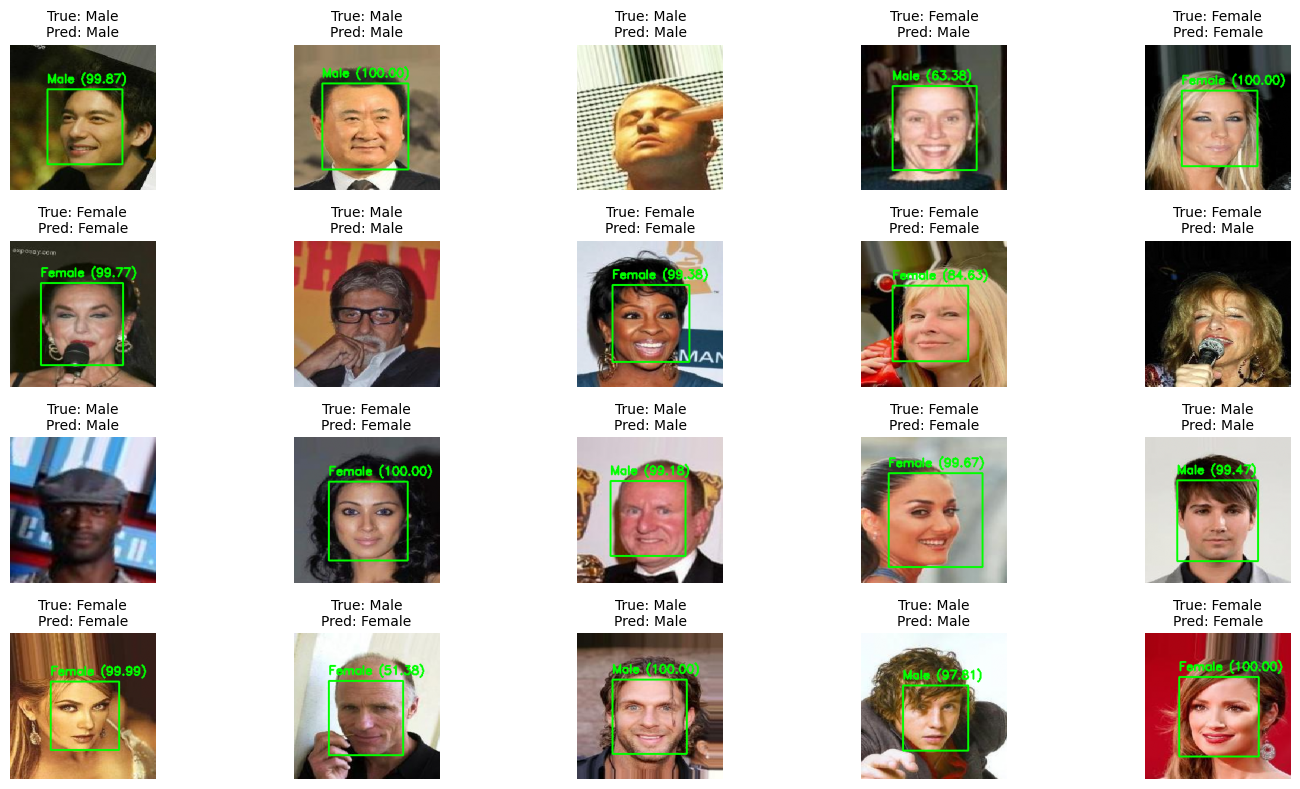

In [20]:
# Load Haar Cascade
haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_alt.xml")

# Fetch test data
x_test, y_test = next(test_data)

# Randomly sample 20 images
n = 20
indices = np.random.choice(x_test.shape[0], size=n, replace=False)

predicted_classes = []
predicted_probabilities = []
images_with_boxes = []  # Store images with rectangles for display

for idx in indices:
    # Extract the image
    original_image = x_test[idx]  # Original RGB image in range [0, 1]
    scaled_image = (original_image * 255).astype('uint8')  # Scale to [0, 255]

    # Prepare the image for prediction
    image = np.expand_dims(original_image, axis=0)
    prediction = model.predict(image, verbose=0)[0][0]*100  # Get the probability for the positive class
    predicted_class = 1 if prediction > 50 else 0
    if(predicted_class == 0):
        prediction = 100 - prediction
    predicted_classes.append(predicted_class)
    predicted_probabilities.append(prediction)

    # Convert to grayscale for Haar cascade
    grayscale_image = cv2.cvtColor(scaled_image, cv2.COLOR_RGB2GRAY)
    faces = haar_cascade.detectMultiScale(grayscale_image, scaleFactor=1.1, minNeighbors=5)

    # Drawing rectangles on a copy of the original image
    image_with_boxes = scaled_image.copy()
    for (x, y, w, h) in faces:
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Add the predicted label and probability above the rectangle
        label = f"{'Male' if predicted_class == 1 else 'Female'} ({prediction:.2f})"
        cv2.putText(image_with_boxes, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Normalize the image for display in matplotlib
    images_with_boxes.append(image_with_boxes / 255.0)

# Plot the images with labels
plt.figure(figsize=(15, 8))
for i, (idx, image_with_boxes) in enumerate(zip(indices, images_with_boxes)):
    plt.subplot(4, 5, i + 1)
    plt.imshow(image_with_boxes)
    true_label = "Male" if int(y_test[idx]) == 1 else "Female"
    pred_label = "Male" if int(predicted_classes[i]) == 1 else "Female"
    prob = predicted_probabilities[i]
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


## Accuracies and Confusion Matrix

In [21]:
# Loop through the testing data and then predict and calculate the accuracy and cm
y_pred = []
y_true = []
for i in range(len(test_data)):
    x_test, y_test = next(test_data)
    y_pred.extend(model.predict(x_test, verbose=0))
    y_true.extend(y_test)

y_pred = np.array(y_pred).flatten()
y_true = np.array(y_true).flatten()
y_pred = [1 if i > 0.5 else 0 for i in y_pred]

# Test Accuracy
correct = np.sum(y_pred == y_true)
total = len(y_true)
accuracy = correct / total


In [22]:
print(f"Accuracy on the test set = {(accuracy*100):0.2f}%")

Accuracy on the test set = 96.61%


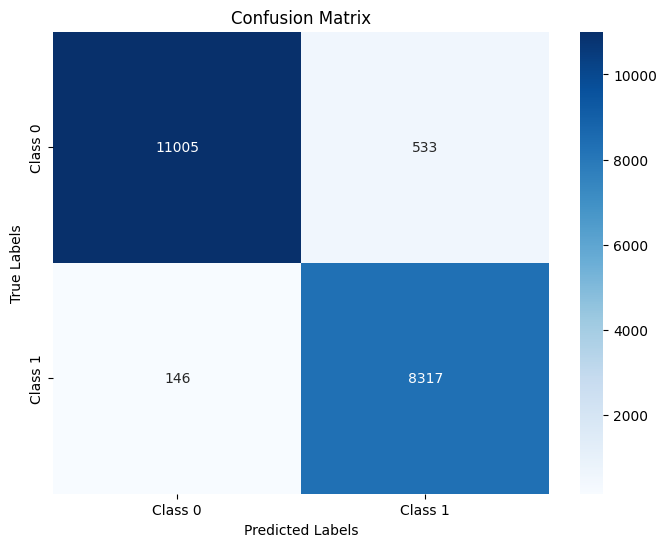

In [23]:
cm = confusion_matrix(y_true, y_pred)
# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [24]:
# Classification Report
print(classification_report(y_true, y_pred, target_names=["Male", "Female"]))

              precision    recall  f1-score   support

        Male       0.99      0.95      0.97     11538
      Female       0.94      0.98      0.96      8463

    accuracy                           0.97     20001
   macro avg       0.96      0.97      0.97     20001
weighted avg       0.97      0.97      0.97     20001

